# 训练分类器

## 数据

通常来说，当必须处理图像、文本、音频或视频数据时，可以使用python标准库将数据加载到 `numpy` 数组里。然后将这个数组转化成 `torch.Tensor`。

* 对于图片，有 `Pillow`，`OpenCV` 等包可以使用
* 对于音频，有 `scipy` 和 `librosa` 等包可以使用
* 对于文本，不管是原生python的或者是基于Cython的文本，可以使用 `NLTK` 和 `SpaCy`。

特别对于视觉方面，创建了一个包，名字叫 `torchvision` ，其中包含了针对 `Imagenet` 、 `CIFAR10` 、 `MNIST` 等常用数据集的数据加载器`（data loaders）` ，还有对图片数据变形的操作，即 `torchvision.datasets` 和 `torch.utils.data.DataLoader`。

这提供了极大的便利，可以避免编写样板代码。

这里，将使用CIFAR10数据集，它有如下的分类：“飞机”，“汽车”，“鸟”，“猫”，“鹿”，“狗”，“青蛙”，“马”，“船”，“卡车”等。

在CIFAR-10里面的图片数据大小是3x32x32，即三通道彩色图，图片大小是32x32像素。

![](https://github.com/pchen12567/picture_store/blob/master/PyTorch/torch_03.jpg?raw=true)

## 训练一个图片分类器

将按顺序做以下步骤：

- 通过 `torchvision` 加载CIFAR10里面的训练和测试数据集，并对数据进行标准化
- 定义卷积神经网络
- 定义损失函数
- 利用训练数据训练网络
- 利用测试数据测试网络

### 加载并标准化 CIFAR10

In [1]:
import torch
import torchvision as tv
import torchvision.transforms as transforms

torchvision数据集加载完后的输出是范围在[0, 1]之间的PILImage。将其标准化为范围在[-1, 1]之间的张量。

In [2]:
# 第一次运行程序torchvision会自动下载CIFAR-10数据集，
# 大约100M，需花费一定的时间，
# 如果已经下载有CIFAR-10，可通过root参数指定

# 定义对数据的预处理
transform = transforms.Compose([
        transforms.ToTensor(), # 转为Tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # 归一化
                             ])

# 训练集
trainset = tv.datasets.CIFAR10(
                    root='./data/', 
                    train=True, 
                    download=True,
                    transform=transform)

trainloader = torch.utils.data.DataLoader(
                    trainset, 
                    batch_size=4,
                    shuffle=True, 
                    num_workers=2)

# 测试集
testset = tv.datasets.CIFAR10(
                    './data/',
                    train=False, 
                    download=True, 
                    transform=transform)

testloader = torch.utils.data.DataLoader(
                    testset,
                    batch_size=4, 
                    shuffle=False,
                    num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


展示训练数据的图片

In [3]:
import matplotlib.pyplot as plt
import numpy as np

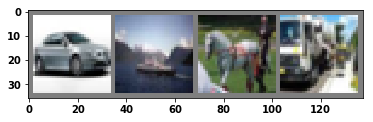

  car  ship horse truck


In [4]:
# 输出图像的函数
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# 随机得到一些训练图片
dataiter = iter(trainloader)
images, labels = dataiter.next()

# 显示图片
imshow(tv.utils.make_grid(images))
# 打印图片标签
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

Dataset对象是一个数据集，可以按下标访问，返回形如 `(data, label)` 的数据。

ship


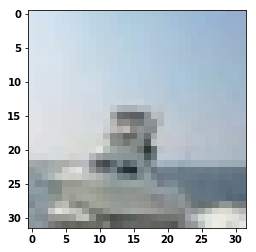

In [5]:
(data, label) = trainset[100]
print(classes[label])

imshow(data)

In [6]:
from torchvision.transforms import ToPILImage

# 可以把Tensor转成Image，方便可视化
show = ToPILImage()

ship


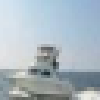

In [7]:
(data, label) = trainset[100]
print(classes[label])

# (data + 1) / 2是为了还原被归一化的数据
show((data + 1) / 2).resize((100, 100))

### 定义卷积神经网络

将之前神经网络章节定义的神经网络拿过来，并将其修改成输入为3通道图像（替代原来定义的单通道图像）

In [8]:
import torch.nn as nn
import torch.nn.functional as F

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()
print(net)

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


### 定义损失函数和优化器

使用分类的交叉熵损失和随机梯度下降（使用momentum）。

In [10]:
from torch import optim

In [11]:
# 交叉熵损失函数
criterion = nn.CrossEntropyLoss()

# 随机梯度下降
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

### 训练网络

只需要遍历数据迭代器，并且输入“喂”给网络和优化函数。

所有网络的训练流程都是类似的，不断地执行如下流程：
- 输入数据
- 前向传播+反向传播
- 更新参数

In [12]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.273
[1,  4000] loss: 1.934
[1,  6000] loss: 1.743
[1,  8000] loss: 1.610
[1, 10000] loss: 1.526
[1, 12000] loss: 1.491
[2,  2000] loss: 1.401
[2,  4000] loss: 1.378
[2,  6000] loss: 1.362
[2,  8000] loss: 1.341
[2, 10000] loss: 1.317
[2, 12000] loss: 1.283
Finished Training


此处仅训练了2个epoch（遍历完一遍数据集称为一个epoch），来看看网络有没有效果。将测试图片输入到网络中，计算它的label，然后与实际的label进行比较。

### 使用测试数据测试网络

已经在训练集上训练了2遍网络。但是需要检查网络是否学到了一些东西。

将通过预测神经网络输出的标签来检查这个问题，并和正确样本进行（ground-truth）对比。如果预测是正确的，将样本添加到正确预测的列表中。

第一步，显示测试集中的图像来熟悉一下。

`Dataloader` 是一个可迭代的对象，它将 `dataset` 返回的每一条数据拼接成一个 `batch` ，并提供多线程加速优化和数据打乱等操作。

当程序对 `dataset` 的所有数据遍历完一遍之后，相应的对 `Dataloader` 也完成了一次迭代。

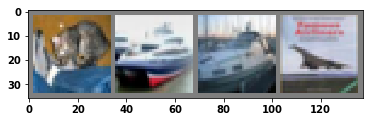

GroundTruth:    cat  ship  ship plane


In [13]:
dataiter = iter(testloader)
images, labels = dataiter.next()  # 一个batch返回4张图片

# 输出图片
imshow(tv.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

接着计算网络预测的label：

In [14]:
# 计算图片在每个类别上的分数
outputs = net(images)

输出是10个类别的量值。一个类的值越高，网络就越认为这个图像属于这个特定的类。让我们得到最高量值的下标/索引；

In [15]:
# 得分最高的那个类
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(4)))

Predicted:    cat  ship   car plane


让我们看看网络在整个数据集上表现的怎么样。

In [16]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 53 %


这比随机选取（即从10个类中随机选择一个类，正确率是10%）要好很多。看来网络确实学到了一些东西。

那么哪些是表现好的类呢？哪些是表现的差的类呢？

In [17]:
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

# 由于测试的时候不需要求导，可以暂时关闭autograd，提高速度，节约内存
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of plane : 58 %
Accuracy of   car : 71 %
Accuracy of  bird : 35 %
Accuracy of   cat : 62 %
Accuracy of  deer : 35 %
Accuracy of   dog : 16 %
Accuracy of  frog : 73 %
Accuracy of horse : 56 %
Accuracy of  ship : 71 %
Accuracy of truck : 58 %


## 在GPU上训练

与将一个张量传递给GPU一样，可以这样将神经网络转移到GPU上。

如果有cuda可用的话，首先定义第一个设备为可见cuda设备：

In [18]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cpu


假设device是CUDA。

然后这些方法将递归遍历所有模块，并将它们的参数和缓冲区转换为CUDA张量。

不得不将输入和目标在每一步都送入GPU。

In [19]:
net.to(device)
images = images.to(device)
labels = labels.to(device)
output = net(images)
loss= criterion(output,labels)

print(loss)

tensor(0.8488, grad_fn=<NllLossBackward>)


如果发现在GPU上并没有比CPU提速很多，实际上是因为网络比较小，GPU没有完全发挥自己的真正实力。